In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score
)

import wandb

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image


In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

wandb.init(
    project="skin_lesion_detection",
    name="resnet50_full_metrics",
    reinit=True
)


wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Device: cuda


wandb: Currently logged in as: adam19285adam (adam19285adam-spu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


In [3]:
BASE_DIR = r"C:\Users\ASUS\Desktop\Projects\skin_lesion_detection\Data\dataverse_files"
IMAGE_DIR = os.path.join(BASE_DIR, "HAM10000_images_combined_600x450")
META_DIR  = os.path.join(BASE_DIR, "HAM10000_metadata")
CSV_PATH  = os.path.join(META_DIR, "HAM10000_metadata.csv")


In [4]:
BASE_DIR = r"C:\Users\ASUS\Desktop\Projects\skin_lesion_detection\Data\dataverse_files"
IMAGE_DIR = os.path.join(BASE_DIR, "HAM10000_images_combined_600x450")
CSV_PATH  = os.path.join(BASE_DIR, "HAM10000_metadata") 

In [5]:
import pandas as pd

df = pd.read_csv(CSV_PATH)
df = df[["image_id", "dx"]]
print(df.head())
print(df["dx"].value_counts())


       image_id   dx
0  ISIC_0027419  bkl
1  ISIC_0025030  bkl
2  ISIC_0026769  bkl
3  ISIC_0025661  bkl
4  ISIC_0031633  bkl
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [6]:
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["dx"],
    random_state=42
)


In [ ]:
# # تحويلات إضافية يمكن إضافتها:
# train_transforms_enhanced = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((256, 256)),  # حجم أكبر ثم قص عشوائي
#     transforms.RandomCrop((224, 224)),  # قص عشوائي
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # إزاحة
#     transforms.RandomVerticalFlip(p=0.5),  # قلب عمودي
#     transforms.RandomApply([transforms.GaussianBlur(3)], p=0.1),  # ضبابية
#     transforms.ToTensor(),
#     transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
# ])

In [ ]:
# train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df["dx"])
# val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["dx"])

In [7]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


In [ ]:
# from torch.utils.data import WeightedRandomSampler

# # حساب الأوزان للفئات
# class_counts = df["dx"].value_counts().to_dict()
# class_weights = {cls: 1.0/count for cls, count in class_counts.items()}
# sample_weights = [class_weights[cls] for cls in df["dx"]]
# sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

In [8]:
class HAMDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.classes = sorted(df["dx"].unique())
        self.class_to_idx = {c:i for i,c in enumerate(self.classes)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = self.df.loc[idx, "image_id"]
        label  = self.df.loc[idx, "dx"]
        img_path = f"{self.image_dir}/{img_id}.jpg"
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image, self.class_to_idx[label]


In [ ]:
# train_dataset = HAMDataset(train_df, IMAGE_DIR, transform=train_transforms)
# val_dataset   = HAMDataset(val_df, IMAGE_DIR, transform=val_transforms)

# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)

# classes = train_dataset.classes
# print(classes)


In [9]:
train_dataset = HAMDataset(df, IMAGE_DIR, transform=train_transforms)
val_dataset   = HAMDataset(df, IMAGE_DIR, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)

classes = train_dataset.classes
print(classes)


['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


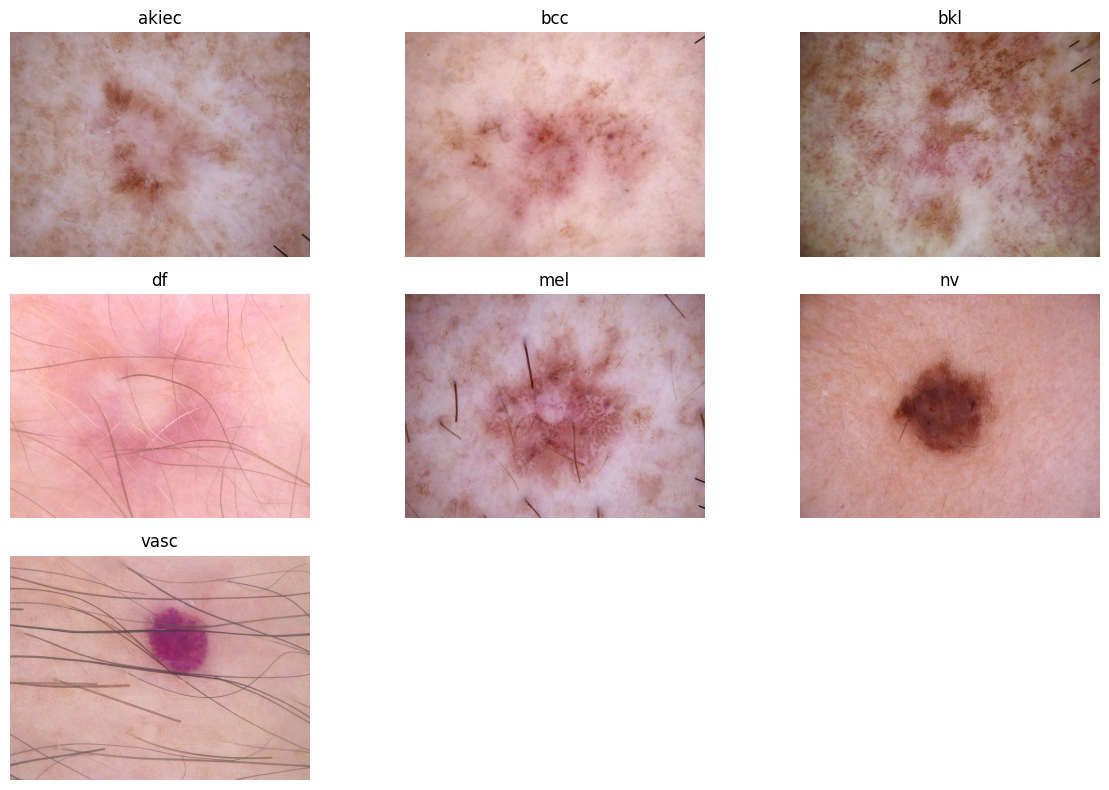

In [10]:
plt.figure(figsize=(12,8))

for i, cls in enumerate(classes):
    idx = train_df[train_df["dx"] == cls].index[0]
    img_id = train_df.loc[idx, "image_id"]
    img = cv2.imread(os.path.join(IMAGE_DIR, img_id + ".jpg"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [11]:
model = models.resnet50(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, len(classes))
model = model.to(DEVICE)


In [12]:
class_counts = train_df["dx"].value_counts().sort_index()
weights = 1.0 / torch.tensor(class_counts.values, dtype=torch.float)

criterion = nn.CrossEntropyLoss(weight=weights.to(DEVICE))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


# 1

In [14]:
train_losses = []
val_accuracies = []

for epoch in range(10):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # ===== Validation =====
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    prec = precision_score(all_labels, all_preds, average="macro")
    rec  = recall_score(all_labels, all_preds, average="macro")
    f1   = f1_score(all_labels, all_preds, average="macro")

    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    })

    print(f"""
Epoch {epoch+1}
Loss      : {train_loss:.4f}
Accuracy  : {acc:.4f}
Precision : {prec:.4f}
Recall    : {rec:.4f}
F1-score  : {f1:.4f}
""")



Epoch 1
Loss      : 1.2677
Accuracy  : 0.6479
Precision : 0.4593
Recall    : 0.6963
F1-score  : 0.5132


Epoch 2
Loss      : 1.0016
Accuracy  : 0.6903
Precision : 0.4826
Recall    : 0.7386
F1-score  : 0.5492


Epoch 3
Loss      : 0.8962
Accuracy  : 0.7064
Precision : 0.6250
Recall    : 0.7674
F1-score  : 0.6631


Epoch 4
Loss      : 0.8027
Accuracy  : 0.7154
Precision : 0.6166
Recall    : 0.8179
F1-score  : 0.6831


Epoch 5
Loss      : 0.7506
Accuracy  : 0.8023
Precision : 0.6763
Recall    : 0.8208
F1-score  : 0.7292


Epoch 6
Loss      : 0.7110
Accuracy  : 0.7398
Precision : 0.6473
Recall    : 0.8399
F1-score  : 0.7055


Epoch 7
Loss      : 0.6187
Accuracy  : 0.7303
Precision : 0.7136
Recall    : 0.7926
F1-score  : 0.7211


Epoch 8
Loss      : 0.6020
Accuracy  : 0.7761
Precision : 0.6742
Recall    : 0.8467
F1-score  : 0.7322


Epoch 9
Loss      : 0.5471
Accuracy  : 0.7990
Precision : 0.6350
Recall    : 0.8441
F1-score  : 0.6788


Epoch 10
Loss      : 0.5335
Accuracy  : 0.8056
Precisi

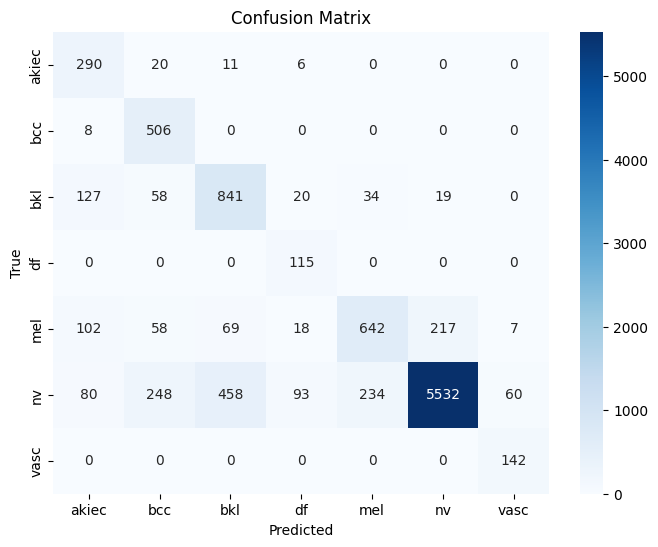

In [15]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=classes,
            yticklabels=classes,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [16]:
print(classification_report(all_labels, all_preds, target_names=classes))


              precision    recall  f1-score   support

       akiec       0.48      0.89      0.62       327
         bcc       0.57      0.98      0.72       514
         bkl       0.61      0.77      0.68      1099
          df       0.46      1.00      0.63       115
         mel       0.71      0.58      0.63      1113
          nv       0.96      0.83      0.89      6705
        vasc       0.68      1.00      0.81       142

    accuracy                           0.81     10015
   macro avg       0.64      0.86      0.71     10015
weighted avg       0.85      0.81      0.81     10015



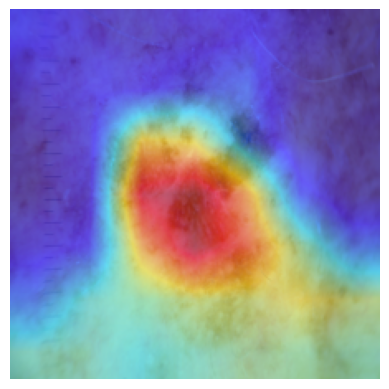

In [17]:
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

image, label = val_dataset[0]
input_tensor = image.unsqueeze(0).to(DEVICE)

grayscale_cam = cam(input_tensor=input_tensor)[0]

img_np = image.permute(1,2,0).numpy()
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

cam_image = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

plt.imshow(cam_image)
plt.axis("off")
plt.show()


# 2

In [13]:
train_losses = []
val_losses   = []   
# val_accuracies = []

accuracies = []
precisions = []
recalls = []
f1_scores = []


for epoch in range(30):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    all_preds = []
    all_labels = []
    running_val_loss = 0 

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)

            loss = criterion(outputs, labels) 
            running_val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = running_val_loss / len(val_loader)
    val_losses.append(val_loss)

    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    prec = precision_score(all_labels, all_preds, average="macro")
    rec  = recall_score(all_labels, all_preds, average="macro")
    f1   = f1_score(all_labels, all_preds, average="macro")

    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)
    
    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    })

    print(f"""
Epoch {epoch+1}
Train Loss : {train_loss:.4f}
Val Loss   : {val_loss:.4f}
Accuracy   : {acc:.4f}
Precision  : {prec:.4f}
Recall     : {rec:.4f}
F1-score   : {f1:.4f}
""")



Epoch 1
Train Loss : 1.2547
Val Loss   : 0.8758
Accuracy   : 0.7230
Precision  : 0.5078
Recall     : 0.6390
F1-score   : 0.5308


Epoch 2
Train Loss : 1.0141
Val Loss   : 0.7764
Accuracy   : 0.7050
Precision  : 0.5244
Recall     : 0.7377
F1-score   : 0.5949


Epoch 3
Train Loss : 0.8744
Val Loss   : 0.6803
Accuracy   : 0.7393
Precision  : 0.5525
Recall     : 0.7782
F1-score   : 0.6269


Epoch 4
Train Loss : 0.8156
Val Loss   : 0.7844
Accuracy   : 0.6801
Precision  : 0.5258
Recall     : 0.7691
F1-score   : 0.5891


Epoch 5
Train Loss : 0.7738
Val Loss   : 0.7301
Accuracy   : 0.7101
Precision  : 0.5718
Recall     : 0.8043
F1-score   : 0.6401


Epoch 6
Train Loss : 0.6660
Val Loss   : 0.7725
Accuracy   : 0.6854
Precision  : 0.5832
Recall     : 0.8006
F1-score   : 0.6299


Epoch 7
Train Loss : 0.6555
Val Loss   : 0.7276
Accuracy   : 0.7332
Precision  : 0.5884
Recall     : 0.8185
F1-score   : 0.6516


Epoch 8
Train Loss : 0.6044
Val Loss   : 0.5650
Accuracy   : 0.7760
Precision  : 0.6532
R

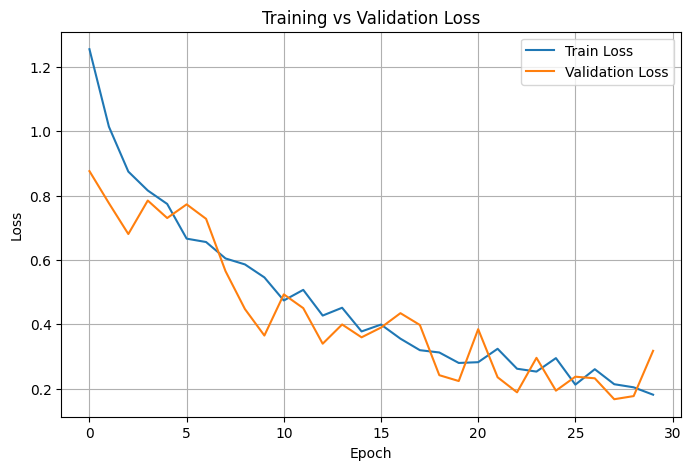

In [14]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


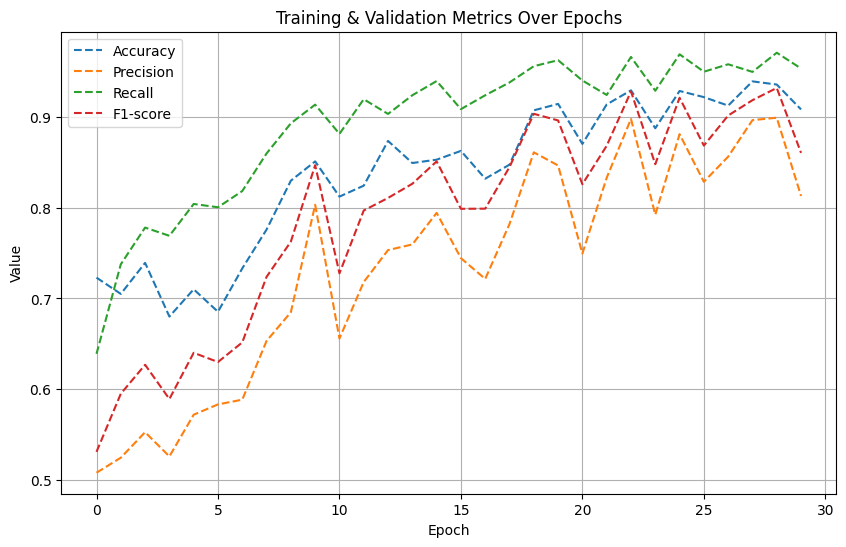

In [16]:
plt.figure(figsize=(10,6))

plt.plot(accuracies, label="Accuracy", linestyle="--")
plt.plot(precisions, label="Precision", linestyle="--")
plt.plot(recalls, label="Recall", linestyle="--")
plt.plot(f1_scores, label="F1-score", linestyle="--")

plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training & Validation Metrics Over Epochs")
plt.legend()
plt.grid(True)

plt.show()


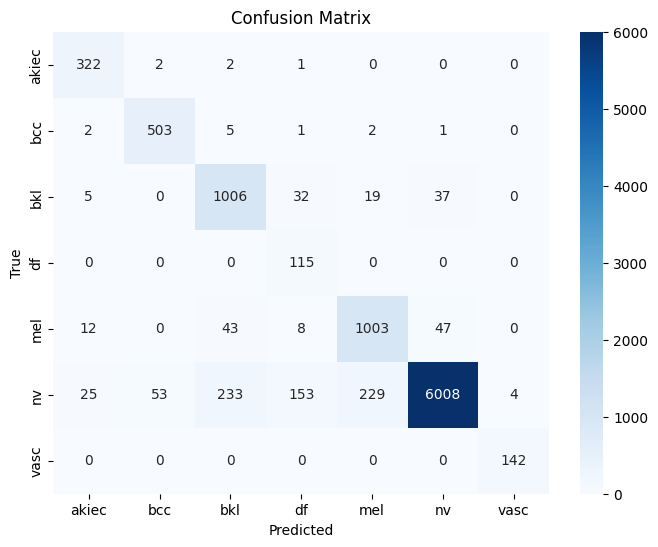

In [17]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=classes,
            yticklabels=classes,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [18]:
print(classification_report(all_labels, all_preds, target_names=classes))


              precision    recall  f1-score   support

       akiec       0.88      0.98      0.93       327
         bcc       0.90      0.98      0.94       514
         bkl       0.78      0.92      0.84      1099
          df       0.37      1.00      0.54       115
         mel       0.80      0.90      0.85      1113
          nv       0.99      0.90      0.94      6705
        vasc       0.97      1.00      0.99       142

    accuracy                           0.91     10015
   macro avg       0.81      0.95      0.86     10015
weighted avg       0.93      0.91      0.91     10015



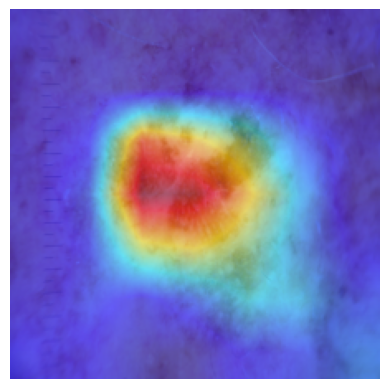

In [19]:
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

image, label = val_dataset[0]
input_tensor = image.unsqueeze(0).to(DEVICE)

grayscale_cam = cam(input_tensor=input_tensor)[0]

img_np = image.permute(1,2,0).numpy()
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

cam_image = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

plt.imshow(cam_image)
plt.axis("off")
plt.show()


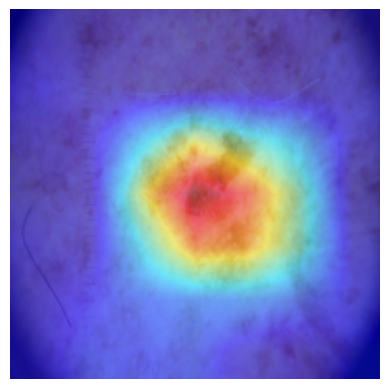

In [20]:
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

image, label = val_dataset[1]
input_tensor = image.unsqueeze(0).to(DEVICE)

grayscale_cam = cam(input_tensor=input_tensor)[0]

img_np = image.permute(1,2,0).numpy()
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

cam_image = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

plt.imshow(cam_image)
plt.axis("off")
plt.show()


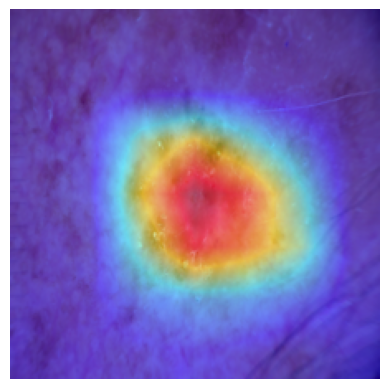

In [21]:
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

image, label = val_dataset[2]
input_tensor = image.unsqueeze(0).to(DEVICE)

grayscale_cam = cam(input_tensor=input_tensor)[0]

img_np = image.permute(1,2,0).numpy()
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

cam_image = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

plt.imshow(cam_image)
plt.axis("off")
plt.show()
